In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import random
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
%matplotlib inline

np.random.seed(42)


%matplotlib inline

data = pd.read_excel('한화생명.xlsx') # 여기서는 Unit root test, Granger Causality, 변동성의 예시로 한화생명 사용했습니다.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        539 non-null    datetime64[ns]
 1   Close       539 non-null    int64         
 2   Volume      539 non-null    int64         
 3   Percentage  539 non-null    float64       
 4   Exchange    539 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 21.2 KB


# Unit root test

In [46]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [47]:
df_1 = data[["Close"]]
df_1 = df_1.dropna()

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_1, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.719776
P-Value                   0.841560
# Lags Used               7.000000
# Observations Used     531.000000
Critical Value (1%)      -3.442725
Critical Value (5%)      -2.866998
Critical Value (10%)     -2.569677
dtype: float64
Is the time series stationary? False


In [48]:
df_2 = data[["Volume"]]
df_2 = df_2.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_2, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        0.776520
P-Value                   0.991248
# Lags Used              19.000000
# Observations Used     519.000000
Critical Value (1%)      -3.443013
Critical Value (5%)      -2.867125
Critical Value (10%)     -2.569745
dtype: float64
Is the time series stationary? False


In [49]:
df_3 = data[["Percentage"]]
df_3 = df_3.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_3, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.423091
P-Value                   0.571157
# Lags Used              14.000000
# Observations Used     524.000000
Critical Value (1%)      -3.442891
Critical Value (5%)      -2.867072
Critical Value (10%)     -2.569716
dtype: float64
Is the time series stationary? False


In [50]:
df_4 = data[["Exchange"]]
df_4 = df_4.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_4, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.660422
P-Value                   0.081141
# Lags Used              10.000000
# Observations Used     528.000000
Critical Value (1%)      -3.442796
Critical Value (5%)      -2.867030
Critical Value (10%)     -2.569694
dtype: float64
Is the time series stationary? False


In [51]:
data = data.set_index('Date')

In [52]:
data_diff = data.diff().dropna()
data_diff.head()

,Close,Volume,Percentage,Exchange
Date,,,,
2018-01-03,100.0,868871.0,-5.16,-68833.0
2018-01-04,0.0,-911898.0,2.75,-74659.0
2018-01-05,50.0,391787.0,2.99,407022.0
2018-01-08,-70.0,-571058.0,-4.50,-544730.0
2018-01-09,-70.0,837651.0,-2.64,9930.0


In [53]:
df_1 = data_diff[["Close"]]
df_1 = df_1.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_1, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -9.515788e+00
P-Value                 3.159956e-16
# Lags Used             6.000000e+00
# Observations Used     5.310000e+02
Critical Value (1%)    -3.442725e+00
Critical Value (5%)    -2.866998e+00
Critical Value (10%)   -2.569677e+00
dtype: float64
Is the time series stationary? True


In [54]:
df_2 = data_diff[["Volume"]]
df_2 = df_2.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_2, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.305790
P-Value                   0.014622
# Lags Used              18.000000
# Observations Used     519.000000
Critical Value (1%)      -3.443013
Critical Value (5%)      -2.867125
Critical Value (10%)     -2.569745
dtype: float64
Is the time series stationary? True


In [55]:
df_3 = data_diff[["Percentage"]]
df_3 = df_3.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_3, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.048537e+01
P-Value                 1.184183e-18
# Lags Used             1.300000e+01
# Observations Used     5.240000e+02
Critical Value (1%)    -3.442891e+00
Critical Value (5%)    -2.867072e+00
Critical Value (10%)   -2.569716e+00
dtype: float64
Is the time series stationary? True


In [56]:
df_4 = data_diff[["Exchange"]]
df_4 = df_4.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_4, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -8.262409e+00
P-Value                 5.041873e-13
# Lags Used             1.500000e+01
# Observations Used     5.220000e+02
Critical Value (1%)    -3.442940e+00
Critical Value (5%)    -2.867093e+00
Critical Value (10%)   -2.569727e+00
dtype: float64
Is the time series stationary? True


In [57]:
tickers = ['Close', 'Volume']

Text(0.5, 1.0, 'Close and  Volume')

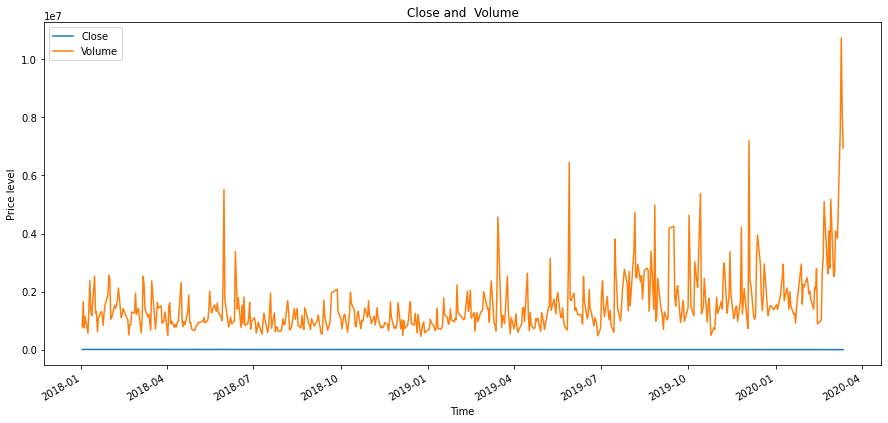

In [58]:
pd.concat([data[tickers[0]], data[tickers[1]]], axis=1).plot(figsize=(15,7))
plt.ylabel('Price level');
plt.xlabel('Time');
title = tickers[0] + ' and  ' + tickers[1]
plt.title(title)

Text(0.5, 1.0, 'Close and  Volume')

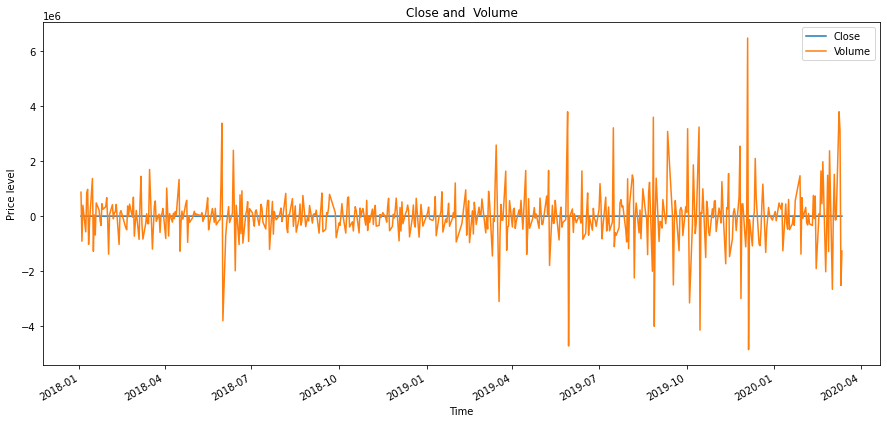

In [59]:
pd.concat([data_diff[tickers[0]], data_diff[tickers[1]]], axis=1).plot(figsize=(15,7))
plt.ylabel('Price level');
plt.xlabel('Time');
title = tickers[0] + ' and  ' + tickers[1]
plt.title(title)

# Granger Causality

In [60]:
data = pd.read_excel("한화생명.xlsx",index_col='Date',sep='\s+',nrows=539)
data.head()

,Close,Volume,Percentage,Exchange
Date,,,,
2018-01-02,6850,787670,8.57,463388
2018-01-03,6950,1656541,3.41,394555
2018-01-04,6950,744643,6.16,319896
2018-01-05,7000,1136430,9.15,726918
2018-01-08,6930,565372,4.65,182188


In [61]:
data_diff = data.diff().dropna()
data_diff.head()

,Close,Volume,Percentage,Exchange
Date,,,,
2018-01-03,100.0,868871.0,-5.16,-68833.0
2018-01-04,0.0,-911898.0,2.75,-74659.0
2018-01-05,50.0,391787.0,2.99,407022.0
2018-01-08,-70.0,-571058.0,-4.50,-544730.0
2018-01-09,-70.0,837651.0,-2.64,9930.0


In [62]:
res = grangercausalitytests(data_diff[['Volume','Close']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3808  , p=0.5374  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=0.3829  , p=0.5360  , df=1
likelihood ratio test: chi2=0.3828  , p=0.5361  , df=1
parameter F test:         F=0.3808  , p=0.5374  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7461  , p=0.4747  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=1.5062  , p=0.4709  , df=2
likelihood ratio test: chi2=1.5040  , p=0.4714  , df=2
parameter F test:         F=0.7461  , p=0.4747  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7637  , p=0.5148  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=2.3214  , p=0.5084  , df=3
likelihood ratio test: chi2=2.3164  , p=0.5094  , df=3
parameter F test:         F=0.7637  , p=0.5148  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5814  , p=0.6762  

In [63]:
res = grangercausalitytests(data_diff[['Percentage','Close']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0586  , p=0.8088  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=0.0590  , p=0.8082  , df=1
likelihood ratio test: chi2=0.0589  , p=0.8082  , df=1
parameter F test:         F=0.0586  , p=0.8088  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0243  , p=0.9760  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=0.0490  , p=0.9758  , df=2
likelihood ratio test: chi2=0.0490  , p=0.9758  , df=2
parameter F test:         F=0.0243  , p=0.9760  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1190  , p=0.9489  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=0.3619  , p=0.9480  , df=3
likelihood ratio test: chi2=0.3618  , p=0.9480  , df=3
parameter F test:         F=0.1190  , p=0.9489  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1500  , p=0.9630  

In [64]:
res = grangercausalitytests(data_diff[['Exchange','Close']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9956  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9956  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9956  , df=1
parameter F test:         F=0.0000  , p=0.9956  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0238  , p=0.9765  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=0.0481  , p=0.9762  , df=2
likelihood ratio test: chi2=0.0481  , p=0.9762  , df=2
parameter F test:         F=0.0238  , p=0.9765  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0402  , p=0.9892  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=0.1223  , p=0.9890  , df=3
likelihood ratio test: chi2=0.1223  , p=0.9890  , df=3
parameter F test:         F=0.0402  , p=0.9892  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0481  , p=0.9956  

In [65]:
res = grangercausalitytests(data_diff[['Close','Volume']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8854  , p=0.3472  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=0.8904  , p=0.3454  , df=1
likelihood ratio test: chi2=0.8896  , p=0.3456  , df=1
parameter F test:         F=0.8854  , p=0.3472  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4851  , p=0.6159  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=0.9794  , p=0.6128  , df=2
likelihood ratio test: chi2=0.9785  , p=0.6131  , df=2
parameter F test:         F=0.4851  , p=0.6159  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8254  , p=0.4803  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=2.5089  , p=0.4737  , df=3
likelihood ratio test: chi2=2.5031  , p=0.4747  , df=3
parameter F test:         F=0.8254  , p=0.4803  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8013  , p=0.5247  

In [66]:
res = grangercausalitytests(data_diff[['Close','Percentage']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0211  , p=0.8846  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=0.0212  , p=0.8842  , df=1
likelihood ratio test: chi2=0.0212  , p=0.8843  , df=1
parameter F test:         F=0.0211  , p=0.8846  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2491  , p=0.7796  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=0.5030  , p=0.7776  , df=2
likelihood ratio test: chi2=0.5028  , p=0.7777  , df=2
parameter F test:         F=0.2491  , p=0.7796  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3862  , p=0.2461  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=4.2138  , p=0.2393  , df=3
likelihood ratio test: chi2=4.1973  , p=0.2409  , df=3
parameter F test:         F=1.3862  , p=0.2461  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0494  , p=0.3810  

In [67]:
res = grangercausalitytests(data_diff[['Close','Exchange']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0335  , p=0.8549  , df_denom=534, df_num=1
ssr based chi2 test:   chi2=0.0336  , p=0.8545  , df=1
likelihood ratio test: chi2=0.0336  , p=0.8545  , df=1
parameter F test:         F=0.0335  , p=0.8549  , df_denom=534, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0601  , p=0.9417  , df_denom=531, df_num=2
ssr based chi2 test:   chi2=0.1213  , p=0.9411  , df=2
likelihood ratio test: chi2=0.1213  , p=0.9411  , df=2
parameter F test:         F=0.0601  , p=0.9417  , df_denom=531, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0487  , p=0.9858  , df_denom=528, df_num=3
ssr based chi2 test:   chi2=0.1481  , p=0.9855  , df=3
likelihood ratio test: chi2=0.1481  , p=0.9855  , df=3
parameter F test:         F=0.0487  , p=0.9858  , df_denom=528, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0856  , p=0.9869  

# 변동성

In [68]:
data = pd.read_excel("한화생명.xlsx", index_col='Date', parse_dates=True)
data.head()

,Close,Volume,Percentage,Exchange
Date,,,,
2018-01-02,6850,787670,8.57,463388
2018-01-03,6950,1656541,3.41,394555
2018-01-04,6950,744643,6.16,319896
2018-01-05,7000,1136430,9.15,726918
2018-01-08,6930,565372,4.65,182188


In [69]:
data = data['Close']

In [70]:
std = data.pct_change().dropna().std() * np.sqrt(504)   # annualized

In [71]:
std

0.39927267905417624

# K-means Clustering

In [72]:
data = pd.read_excel("scaling4.xlsx", index_col='Code', parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, '005930 to '009320
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DailyExchange  99 non-null     float64
 1   DailyVolume    99 non-null     float64
dtypes: float64(2)
memory usage: 2.3+ KB


In [73]:
### oops in python 

class Test:
    def __init__(self, n):
        pass   

    def build(self, input_shape):
        pass 
    def call(self, x):
        return x **2 

In [74]:
from sklearn.cluster import KMeans 

kmeans = KMeans()   # instantiation 

In [75]:
df= data.iloc[:,0:2]

In [76]:
df=df.dropna()

In [77]:
elbow_score = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    elbow_score.append(kmeans.inertia_)   # cluster's coherence

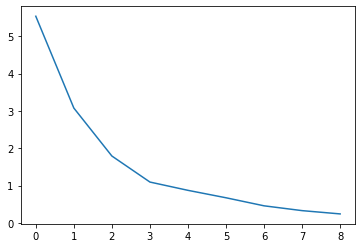

In [78]:
plt.plot(elbow_score)

In [79]:
# based on elbow score 

#k = 12
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(df)
centeroid = kmeans.cluster_centers_

In [80]:
X=df['DailyVolume']
Y=df['DailyExchange']

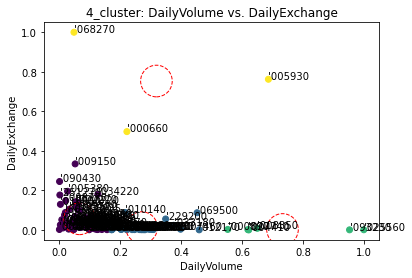

In [81]:
plt.scatter(df['DailyVolume'], df['DailyExchange'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('DailyVolume')
plt.ylabel('DailyExchange') 
plt.title(f"{k}_cluster: DailyVolume vs. DailyExchange")   


mkrs = X.index.tolist()
for i in range(len(df)):
    plt.annotate(mkrs[i], (X[i], Y[i]))

for i in range(len(centeroid)):
    plt.scatter(centeroid[i, 1], centeroid[i, 0], s=1000, marker='o', linestyle="--", edgecolor='r', facecolors="none")
    plt.rcParams["figure.figsize"] = (3,3)